# Advanced DL and RL: Домашнее задание 2

Студент: **Панфилов Александр**

Группа: **MADE-DS-32**

### Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

**Пункт 1**

Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

**Пункт 2**

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def Q_St_At_update(Q, St, At, Rt1, St1, a=0.01, g=1.0):
    if St: # Проверка на первый ход
        Q[St][At] += a * (Rt1 + g * np.max(Q.get(St1, 0)) - Q[St][At])

In [5]:
def choose_move(Q, s, empty_spaces, eps=0.1):
    number_of_moves = len(empty_spaces)
    move = np.random.randint(number_of_moves)
    
    if s in Q:  # знакомое состояние
        if np.random.random() > eps:  # проверка exploration
            move = np.argmax(Q[s])
    else:
        Q[s] = np.zeros(number_of_moves)

    return move, empty_spaces[move]

In [6]:
def conduct_Q_learning_episode(env, pi_1, pi_2, alpha=0.015, epsilon=0.3, gamma=1.0):
    env.reset()
    s, empty_spaces, a = env.getState()
    done = False
    pi_1_s,  pi_1_a = None, None
    pi_2_s, pi_2_a = None, None
    while not done:
        if a == 1:  # Ходят крестики
            move, move_aсtion = choose_move(pi_1, s, empty_spaces, eps=epsilon)
            state_new, reward, done, _ = env.step(move_aсtion)
            
            # Обновим состояние для предыдущего хода (т.е для ноликов)
            Q_St_At_update(pi_2, pi_2_s, pi_2_a, -1*reward, state_new[0], a=alpha, g=gamma)
             
            if reward == 1:
                pi_1[s][move] = 1
                
            pi_1_s, pi_1_a = s, move
            
        elif a == -1:  # Ходят нолики
            move, move_aсtion = choose_move(pi_2, s, empty_spaces, eps=epsilon)  
            state_new, reward, done, _ = env.step(move_aсtion)
            
            if reward == -1:
                pi_2[s][move] = 1
                            
            # Обновим состояние для предыдущего хода (т.е для крестиков)
            Q_St_At_update(pi_1, pi_1_s, pi_1_a, reward, state_new[0], a=alpha, g=gamma)
            pi_2_s, pi_2_a = s, move
            
        s, empty_spaces, a = state_new

In [7]:
def run_experiment(env, pi_1, pi_2, game_type=1):
    env.reset()
    s, empty_spaces, a = env.getState()
    done = False
    while not done:
        if game_type == 1: 
            Q = pi_1
        else:
            Q = pi_2
        if game_type == a:
            eps = 0
        else:
            eps = 1
        move, move_aсtion = choose_move(Q, s, empty_spaces, eps=eps)
        state, reward, done, _ = env.step(move_aсtion)
        s, empty_spaces, a = state
    return reward

def plot_stats(indicies, loses, draws, wins, mode=1):
    plt.figure(figsize=(12, 8))
    plt.plot(indicies, loses, label="Процент проигрышей", linewidth=1.5)
    plt.plot(indicies, draws, label="Процент ничьих", linewidth=1.5)
    plt.plot(indicies, wins, label="Процент побед", linewidth=1.5)
    plt.xlim(left=1)
    plt.xlabel("Количество сыгранных эпизодов")
    plt.ylabel("%")
    if mode == 1:
        plt.title(f"Средние для игры за крестики против случайно стратегии после эпизода {i}")
    else:
        plt.title(f"Средние для игры за нолики против случайно стратегии после эпизода {i}")

    plt.legend()
    plt.grid(True)
    plt.show()


#### Пункт 1

Поле 3 х 3, 3 в ряд

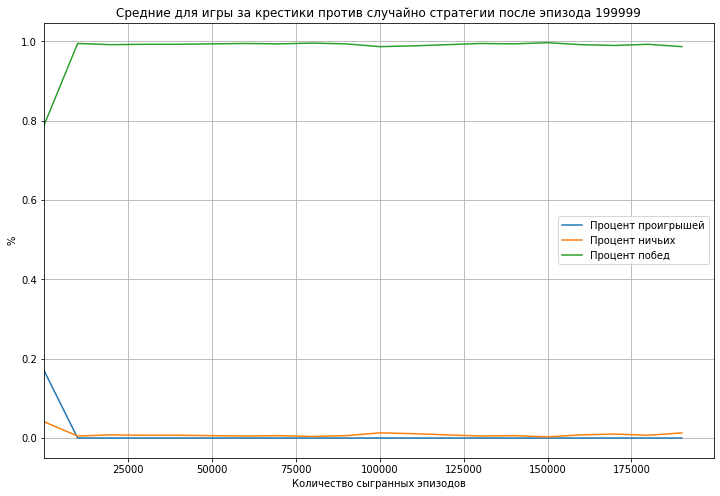

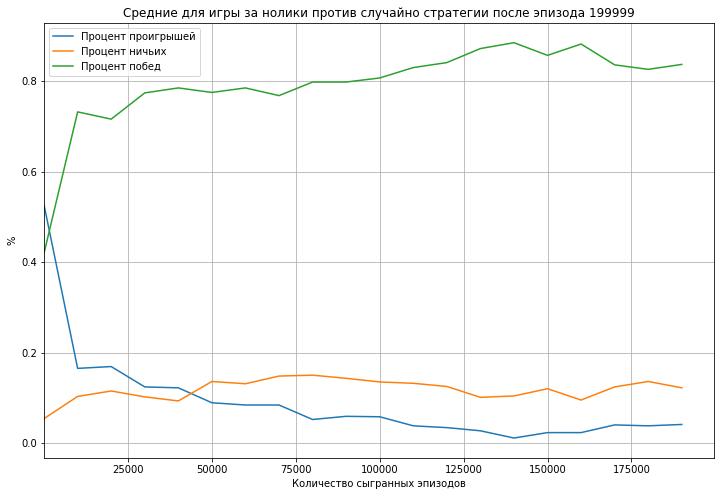

In [8]:
pi_1_3, pi_2_3 = dict(), dict()

env = TicTacToe(3, 3, 3)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]
test_run = 1000

for i in range(200000):
    conduct_Q_learning_episode(env, pi_1_3, pi_2_3, epsilon=0.3)
    if i % 10000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_3, pi_2_3, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_3, pi_2_3, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)

#### Пункт 2

Поля (4 х 4, 4 в ряд) и (5 х 5, 5 в ряд)

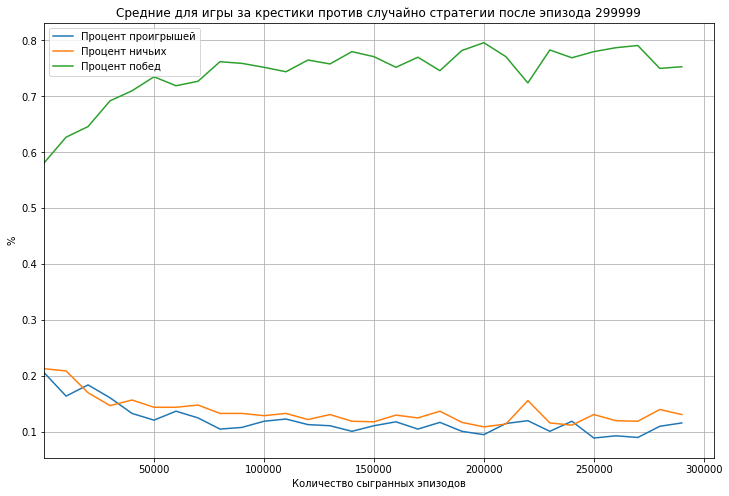

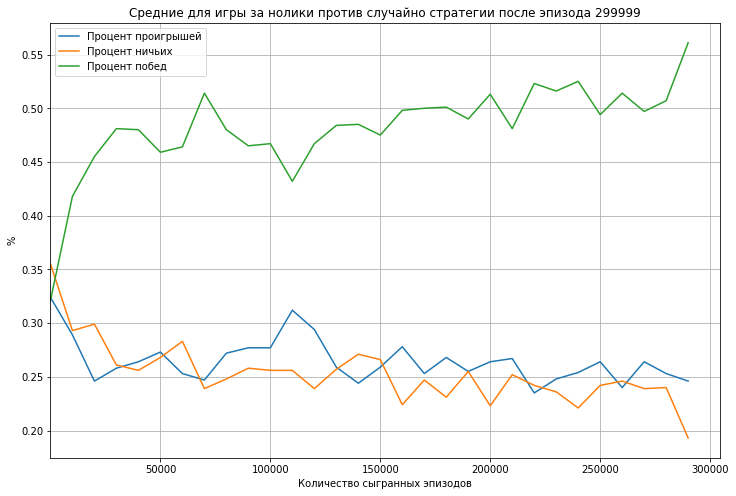

In [9]:
pi_1_4, pi_2_4 = dict(), dict()

env = TicTacToe(4, 4, 4)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]

test_run = 1000
for i in range(300000):
    conduct_Q_learning_episode(env, pi_1_4, pi_2_4, epsilon=0.3)
    if i % 10000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_4, pi_2_4, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_4, pi_2_4, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)

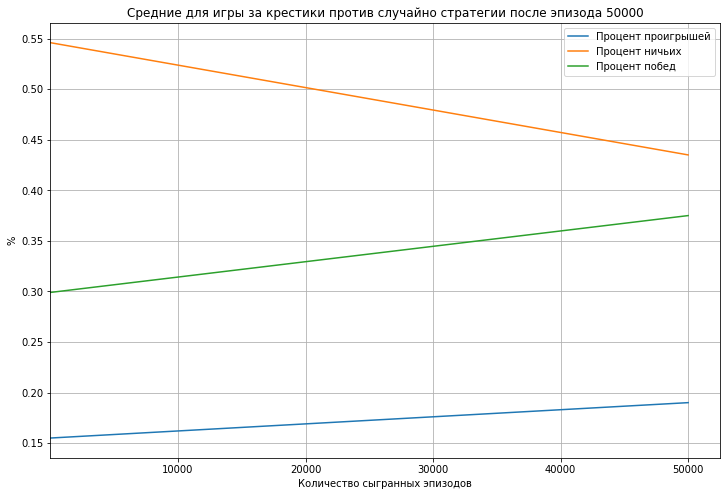

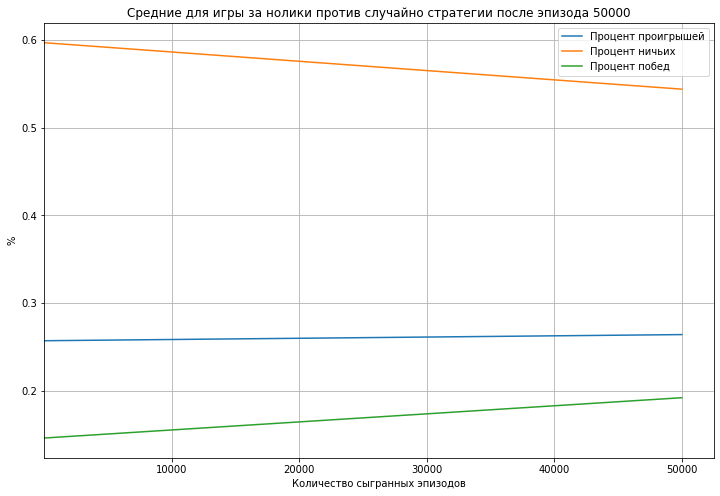

In [ ]:
pi_1_5, pi_2_5 = dict(), dict()

env = TicTacToe(5, 5, 5)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]

test_run = 1000
for i in range(500000):
    conduct_Q_learning_episode(env, pi_1_5, pi_2_5, epsilon=0.35)
    if i % 50000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_5, pi_2_5, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_5, pi_2_5, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)